## Econometric estimation of an IRL-based market portfolio model

Welcome to your final course project on RL in Finance. In this project you will: 

- Explore and estimate an IRL-based model of market returns that is based on IRL of a market-optimal portfolio 
- Investigate the role and impact of choices of different signals on model estimation and trading strategies
- Compare simple IRL-based and UL-based trading strategies

**Instructions for project structure and grading principles :**

- This is a project that will be graded based on a peer-to-peer review. The project consists of four parts. The maximum score for each part is 10, so that maximum score you can give your peers (and they can give you) is 40. The parts are as follows (more detailed instructions are in specific cells below):

- **Part 1**: Complete the model estimation for the DJI portfolio of 30 stocks, and simple signals such as simple moving averages constructed below (Max 10 point).

- **Part 2**: Propose other signals and investigate the dynamics for market caps obtained with alternative signals. Present your conclusions and observations. (Max 10 point).

- **Part 3**: Can you repeat your analysis for the S&P portfolio? You will have to build a data file, build signals, and repeat the model estimation process with your new dataset (Max 10 points).

- **Part 4** : Show me something else. This part is optional. Come up with your own idea of an interesting analysis. For example, you can build a strategy using an optimal market-implied policy estimated from this model, and compare it with PCA and absorption ratio strategies that we built in Course 2. (Max 10 points).

**Instructions for formatting your notebook and packages use can use **

- Use one or more cells of the notebook for each section of the project. Each section is marked by a header cell below. Insert your cells between them without changing the sequence. 

- Think of an optimal presentation of your results and conclusions. Think of how hard or easy it will be for your fellow students to follow your logic and presentation. When you are grading others, you can add or subtract point for the quality of presentation.

- You will be using Python 3 in this project. Using TensorFlow is encouraged but is not strictly necessary, you can use optimization algorithms available in scipy or scikit-learn packages. If you use any non-standard packages, you should state all neccessary additional imports (or instructions how to install any additional modules you use in a top cell of your notebook. If you create a new portfolio for parts 3 and 4 in the project, make your code for creating your dataset replicable as well, so that your grader can reproduce your code locally on his/her machine.   

- Try to write a clean code that can be followed by your peer reviewer. When you are the reviewer, you can add or subtract point for the quality of code. 


**After completing this project you will:**
- Get experience with building and estimation of your first IRL based model of market dynamics, and learn how this IRL approach extends the famous Black-Litterman model (see F. Black and R. Litterman, "Global Portfolio Optimization", Financial Analyst Journal, Sept-Oct. 1992, 28-43, and  D. Bertsimas, V. Gupta, and I.Ch. Paschalidis, "Inverse Optimization: A New Perspective on the Black-Litterman Model", Operations Research, Vol.60, No.6, pp. 1389-1403 (2012), I.Halperin and I. Feldshteyn "Market Self-Learning of Signals, Impact and Optimal Trading: Invisible Hand Inference with Free Energy", https://papers.ssrn.com/sol3/papers.cfm?abstract\_id=3174498.). 
- Know how to enhance a market-optimal portfolio policy by using your private signals. 
- Be able to implement trading strategies based on this method.

Let's get started!

## The IRL-based model of stock returns

In Week 4 lectures of our course we found that optimal investment policy in the problem of inverse portfolio optimization is a Gaussian policy

$$ \pi_{\theta}({\bf a}_t |{\bf y}_t ) =   \mathcal{N}\left({\bf a}_t | \bf{A}_0 + \bf{A}_1 {\bf y}_t, \Sigma_p \right) $$

Here $ {\bf y}_t $ is a vector of dollar position in the portfolio, and $ \bf{A}_0 $, $ \bf{A}_1 $ and $ \Sigma_p $ are parameters defining a Gaussian policy.   

We said in the lecture that such Gaussian policy is found for both cases of a single investor and a market portfolio. We also sketched a numerical scheme that can iteratively compute coefficients $ \bf{A}_0$, $ \bf{A}_1 $ and $ \Sigma_p $ using a combination of a RL algorithm called G-learning and a trajectory optimization algorithm.

In this project, you will explore implications and estimation of this IRL-based model for the most interesting case - the market portfolio. It turns out that for this case, the model can be estimated in an easier way using a conventional Maximum Likelihood approach. To this end, we will re-formulate the model for this particular case in three easy steps.


Recall that for a vector of $ N $ stocks, we introduced a size $ 2 N $-action vector 
$ {\bf a}_t = [{\bf u}_t^{(+)}, {\bf u}_t^{(-)}] $, so that an action $ {\bf u}_t $ was defined as a difference of two non-negative numbers 
$ {\bf u}_t = {\bf u}_t^{(+)} -  {\bf u}_t^{(-)} = [{\bf 1}, - {\bf 1}] {\bf a}_t \equiv {\bf 1}_{-1}^{T} {\bf a}_t $.

Therefore, the joint distribution of $ {\bf a}_t = [{\bf u}_t^{(+)}, {\bf u}_t^{(-)} ] $ is given by our Gaussian policy
$  \pi_{\theta}({\bf a}_t |{\bf y}_t ) $. This means that the distribution of 
$ {\bf u}_t = {\bf u}_t^{(+)} -  {\bf u}_t^{(-)} $ is also Gaussian. Let us write it therefore as follows:

$$
\pi_{\theta}({\bf u}_t |{\bf y}_t ) =   \mathcal{N}\left({\bf u}_t | \bf{U}_0 + \bf{U}_1 {\bf y}_t, \Sigma_u \right) 
$$

Here $ \bf{U}_0 = {\bf 1}_{-1}^{T}  \bf{A}_0 $ and $ \bf{U}_1 =  {\bf 1}_{-1}^{T}  \bf{A}_1 $.

This means that $ {\bf u}_t $ is a Gaussian random variable that we can write as follows:

$$
{\bf u}_t = \bf{U}_0 + \bf{U}_1 {\bf y}_t + \varepsilon_t^{(u)}  = \bf{U}_0 + \bf{U}_1^{(x)} {\bf x}_t + \bf{U}_1^{(z)} {\bf z}_t + \varepsilon_t^{(u)} 
$$

where $ \varepsilon_t^{(u)} \sim \mathcal{N}(0,\Sigma_u) $ is a Gaussian random noise.  

The most important feature of this expression that we need going forward is is linear dependence on the state $ {\bf x}_t $. 
This is the only result that we will use in order to construct a simple dynamic market model resulting from our IRL model. We use a deterministic limit of this equation, where in addition we set $ \bf{U}_0 = \bf{U}_1^{(z)} = 0 $, and replace $ \bf{U}_1^{(x)} \rightarrow \phi $ to simplify the notation. We thus obtain a simple deterministic policy

$$
\label{determ_u}
{\bf u}_t =  \phi  {\bf x}_t 
$$

Next, let us recall the state equation and return equation (where we reinstate a time step $ \Delta t $,
and $ \circ $ stands for an element-wise (Hadamard) product):

$$
X_{t+ \Delta t} = (1 + r_t \Delta t) \circ (  X_t +  u_t  \Delta t)  
$$
$$
r_t   = r_f + {\bf w} {\bf z}_t -  \mu  u_t + \frac{\sigma}{ \sqrt{ \Delta t}} \varepsilon_t 
$$
where $ r_f $ is a risk-free rate, $ \Delta t $ is a time step, $ {\bf z}_t $ is a vector of predictors with weights $ {\bf w} $, $ \mu $ is a market impact parameter with a linear impact specification, and $ \varepsilon_t \sim \mathcal{N} (\cdot| 0, 1) $ is a white noise residual.


Eliminating $ u_t $ from these expressions and simplifying, we obtain
$$ \Delta  X_t = \mu  \phi  ( 1 + \phi \Delta t) \circ  X_t \circ \left(  \frac{r_f (1 + \phi \Delta t)  + \phi}{ \mu \phi (1+ \phi \Delta t )}  -  X_t \right) \Delta t + 
( 1 + \phi \Delta t) X_t  \circ \left[ {\bf w} {\bf z}_t  \Delta t +  \sigma \sqrt{ \Delta t} \varepsilon_t \right]
$$
Finally, assuming that $ \phi \Delta t \ll 1 $ and taking the continuous-time limit $  \Delta t \rightarrow dt $, we obtain 

$$
d X_t = \kappa \circ X_t \circ \left( \frac{\theta}{\kappa} - X_t \right) dt +  X_t \circ \left[ {\bf w} {\bf z}_t \, dt + \sigma d W_t \right]
$$
where $\kappa   =   \mu  \phi $, $ \theta  =   r_f + \phi $, and $ W_t $ is a standard Brownian motion.

Please note that this equation describes dynamics with a quadratic mean reversion. It is quite different from models with linear mean reversion such as the Ornstein-Uhlenbeck (OU) process. 

Without signals $ {\bf z}_t $, this process is known in the literature as a Geometric Mean Reversion (GMR) process. It has been used (for a one-dimensional setting) by Dixit and Pyndick (" Investment Under Uncertainty", Princeton 1994), and investigated (also for 1D) by Ewald and Yang ("Geometric Mean Reversion: Formulas for the Equilibrium Density and Analytic Moment Matching", {\it University of 
St. Andrews Economics Preprints}, 2007). We have found that such dynamics (in a multi-variate setting) can also be obtained for market caps (or equivalently for stock prices, so long as the number of shares is held fixed) using Inverse Reinforcement Learning! 

(For more details, see I. Halperin and I. Feldshteyn, "Market Self-Learning of Signals, Impact and Optimal Trading: Invisible Hand Inference with Free Energy.
(or, How We Learned to Stop Worrying and Love Bounded Rationality)", https://papers.ssrn.com/sol3/papers.cfm?abstract\_id=3174498) 


In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
from datetime import datetime

In [2]:
# read the data to a Dataframe
df_cap = pd.read_csv('dja_cap.csv')

In [3]:
# add dates
dates = pd.bdate_range(start='2010-01-04', end=None, periods=df_cap.shape[0], freq='B')
df_cap['date'] = dates

df_cap.set_index('date',inplace=True)
df_cap.head()


,AAPL,AXP,BA,CAT,CSCO,CVX,DIS,DWDP,GE,GS,...,NKE,PFE,PG,TRV,UNH,UTX,V,VZ,WMT,XOM
date,,,,,,,,,,,,,,,,,,,,,
2010-01-04,1.937537e+11,48660795480,4.082033e+10,36460724400,1.420313e+11,1.586155e+11,6.168697e+10,3.337392e+10,1.645038e+11,8.897731e+10,...,25598248500,1.527563e+11,178576382080,27214839130,36638396010,67155918570,41337043020,94536765440,206625627560,3.272107e+11
2010-01-05,1.940887e+11,48553770270,4.215727e+10,36896634000,1.413985e+11,1.597391e+11,6.153308e+10,3.486077e+10,1.653556e+11,9.055040e+10,...,25700093100,1.505775e+11,178634816760,26570118990,36580295160,66152751840,40863360090,94707204320,204568134680,3.284884e+11
2010-01-06,1.910015e+11,49338621810,4.343609e+10,37008725040,1.404781e+11,1.597591e+11,6.120609e+10,3.547838e+10,1.645038e+11,8.958393e+10,...,25543409100,1.500934e+11,177787513900,26193121620,36940520430,65805862410,40314638280,90673484160,204110914040,3.313275e+11
2010-01-07,1.906484e+11,49921314620,4.519446e+10,37158179760,1.411109e+11,1.591572e+11,6.122532e+10,3.550126e+10,1.730218e+11,9.133695e+10,...,26172872700,1.495285e+11,176823341680,26570118990,38358181170,66087124110,40689832680,90133761040,204225219200,3.302865e+11
2010-01-08,1.919159e+11,49885639550,4.475850e+10,37575407520,1.418587e+11,1.594381e+11,6.132150e+10,3.562706e+10,1.767484e+11,8.960963e+10,...,26121202640,1.507389e+11,176589602960,26531872880,37997955900,66218379570,40802391000,90190574000,203196472760,3.289615e+11


## Let us build some signals 

Here we provide a "warm start" by computing two simple moving average signals that you can use as benchmark in your analysis.

### Generate moving averages

In [4]:
# Calculating the short-window (10 days) simple moving average

window_1 = 10

short_rolling = df_cap.rolling(window=window_1).mean()
# short_rolling.head(20)

In [5]:
# Calculating the long-window (30 days) simple moving average

window_2 = 30
long_rolling = df_cap.rolling(window=window_2).mean()

### Plot three years of AAPL stock:

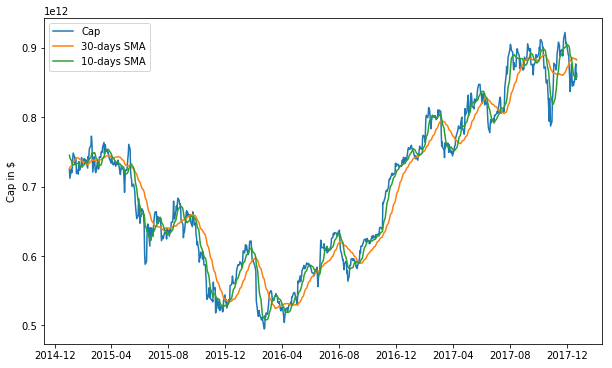

In [6]:
ticker = 'AAPL'
start_date = '2015-01-01'
end_date = '2017-12-31'

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1,1,1)

ax.plot(df_cap.loc[start_date:end_date, :].index, df_cap.loc[start_date:end_date, 'AAPL'], label='Cap')
ax.plot(long_rolling.loc[start_date:end_date, :].index, long_rolling.loc[start_date:end_date, 'AAPL'], 
          label = '%d-days SMA' % window_2)
ax.plot(short_rolling.loc[start_date:end_date, :].index, short_rolling.loc[start_date:end_date, 'AAPL'], 
         label = '%d-days SMA' % window_1)

ax.legend(loc='best')
ax.set_ylabel('Cap in $')

plt.show()

## Part 1: Model calibration with moving average signals (Max 10 points)

Recall the equation for the dynamics of market portfolio: 

$$ \Delta {\bf x}_t = \kappa_x \circ  {\bf x}_t \circ 
\left( {\bf W}{\bf z}_t'  - {\bf x}_t \right)  +  {\bf x}_t  \circ \varepsilon_t^{(x)} $$

Here we change the notation a bit. Now $ {\bf z}_t' $ is an extended vector of predictors that includes a constant unit predictor $  {\bf z}_t' = [1, {\bf z}_t ]^T $. Therefore, for each name, if you have $ K = 2 $ signals, an extended vector of signals $ {\bf z}_t' $ is of length $ K + 1 $, and the  $ W $ stands for a factor loading matrix.
The negative log-likelihood function for observable data with this model is therefore

$$  LL_M (\Theta) = - \log \prod_{t=0}^{T-1} 
\frac{1}{ \sqrt{ (2 \pi)^{N}  \left| \Sigma_x \right| }} 
e^{ - \frac{1}{2} \left(   {\bf v}_t
 \right)^{T} 
\Sigma_x^{-1}  
\left(  {\bf v}_t \right)} $$

where

$$  {\bf v}_t \equiv \frac{{\bf x}_{t+1} -  {\bf x}_{t}}{{\bf x}_{t}}  
-  \kappa_x \circ \left({\bf W} {\bf z}_t'   - {\bf x}_t \right)  $$

and $ \Sigma_x $ is the covariance matrix that was specified above in terms of other parameters. Here we directly infer the value of $ \Sigma_x $, along with other parameters, from data, so we will not use these previous expressions. 

Parameters that you have to estimate from data are therefore the vector of mean reversion speed 
parameters $ \kappa_x $, factor loading matrix $ {\bf W} \equiv {\bf w}_z' $, and covariance matrix $ \Sigma_x $. 

Now, you are free to impose some structure on this parameters. Here are some choice, in the order of increasing complexity:

- assume that all values in vector-valued and matrix-valued parameters are the same, so that they can parametrized by scalars, e.g. $ \kappa_x = \kappa {\bf 1}_N $ where $ \kappa $ is a scalar value, and $ {\bf 1}_N $ is a vector of ones of length $ N $ where $ N $ is the number of stocks in the market portfolio. You can proceed similarly with specification of factor loading matrix $ W' $. Assume that all values in (diagonal!) factor loading matrices are the same for all names, and assume that all correlations and variances in the covariance matrix $ \Sigma_x $ are the same for all names.   

- Assume that all values are the same only within a given industrial sector.


- You can also change the units. For example, you can consider logs of market caps instead of market caps themselves, ie. change the variable from $ {\bf x}_t  $ to $ {\bf q}_t = \log {\bf x}_t $


# Data Manipulation

To calculate the average of market cap, takedn sum() and then the mean along the axis = 1(column wise).

Removed NaN values using first_valid_index()

Demeaned using pct_change()

In [7]:
average_market_cap = df_cap.sum(axis=1).mean()

# Average
short_rolling_average = short_rolling / average_market_cap
long_rolling_average = long_rolling / average_market_cap
df_cap_average = df_cap / average_market_cap
#
# By looking at the debug cells below, we see that both heads for the long and short de-meaned pandas Dataframes have NaN 
# (Not-a-number.)
# Going to only start with the first valid number
# Using .first_valid_index
# https://stackoverflow.com/questions/42137529/pandas-find-first-non-null-value-in-column
short_rolling_average_first_valid = (short_rolling_average 
                                    /
                                    short_rolling_average.loc[ short_rolling_average.first_valid_index() ])
long_rolling_average_first_valid = (long_rolling_average
                                   /
                                   long_rolling_average.loc[ long_rolling_average.first_valid_index() ])


# De-mean
# https://www.youtube.com/watch?v=E5PZR4YpBtM
short_rolling_demeaned = short_rolling_average_first_valid.pct_change(periods=1).shift(-1)
long_rolling_demeaned = long_rolling_average_first_valid.pct_change(periods=1).shift(-1)

# Data Cleaning

In [8]:


# Drop last row
market_cap = df_cap_average[:-1]

# Drop not-a-numbers
signal_1 = short_rolling_demeaned.copy()
signal_2 = long_rolling_demeaned.copy()
#
signal_1 = signal_1.dropna()
signal_2 = signal_2.dropna()

# # To get rid of rows where dates do not match
market_cap = market_cap[ market_cap.index.isin(signal_1.index) & market_cap.index.isin(signal_2.index)]
signal_1 = signal_1[signal_1.index.isin( market_cap.index )]
signal_2 = signal_2[signal_2.index.isin( market_cap.index )]

# Get the amount of time steps

In [9]:
t = market_cap.shape[0]
t

2050

# Number of stocks

In [10]:
n = market_cap.shape[1]
n

30

# Calibration

In [11]:

start_date = '2010-1-1'
end_date = '2017-12-31'

# Only get the dates required
market_cap_focused = market_cap.loc[ start_date : end_date ]
signal_1_focused = signal_1.loc[ start_date : end_date ]
signal_2_focused = signal_2.loc[ start_date : end_date ]

# Mentioned in the instructions, 2 signals means k = 2
k = 2

# Result Dataframe

In [12]:


results = pd.DataFrame( [],
                        index = market_cap_focused.columns,
                        columns = [ 'kappa',
                                    'sigma',
                                    'sigma^2',
                                    'w1',
                                    'w2'] )

# Tensorflow graph

In [13]:

tf.reset_default_graph()

# Input
x = tf.placeholder( shape = (None, n),
                    dtype = tf.float32,
                    name = 'x' )

# Signals
z1  = tf.placeholder( shape = (None,n),
                      dtype = tf.float32,
                      name = 'z1' ) 
z2  = tf.placeholder( shape = ( None, n),
                      dtype=tf.float32,
                      name = 'z2' )

# Variables
N_k = n
N_s = n
N_w = n
kappa = tf.get_variable( "kappa",
                         initializer = tf.random_uniform(
                                             [N_k], 
                                             minval = 0.0,
                                             maxval = 1.0) )
sigma = tf.get_variable( "sigma",
                         initializer = tf.random_uniform( 
                                             [N_s],
                                             minval=0.0,
                                             maxval=0.1) )

# Weights
#-------------------
w1_init = tf.random_normal( [N_w],
                            mean=0.5,
                            stddev=0.1 )
w2_init = 1 - w1_init
w1 = tf.get_variable( "w1",
                      initializer = w1_init)
w2 = tf.get_variable( "w2",
                      initializer=w2_init )

W1 = w1*tf.ones(n)
W2 = w2*tf.ones(n)


# Gaussian
#-------------------
mu    = tf.zeros( [n] )
Sigma = sigma*tf.ones( [n] )
theta1 = tf.multiply( W1,
                      z1)
theta2 = tf.multiply( W2,
                      z2)
scale  = tf.slice( x,
                   [0,0],
                   [1,-1] )
theta  = tf.multiply( scale,
                      tf.cumprod( 1 + tf.add( theta1,
                                              theta2) ) )

Kappa = kappa*tf.ones( [n] )

r = tf.divide( tf.subtract( tf.manip.roll( x,
                                           shift = -1,
                                           axis = 0),
                            x),
               x)
v = tf.subtract( r, 
                 tf.multiply( Kappa,
                              tf.subtract( theta,
                                           x) ) )
# NOTE: Do not use last row
vuse = tf.slice( v,
                 [0,0],
                 [tf.shape(v)[0]-1,-1] )

#  Constraint - No negative
#-------------------
clip_w1 = w1.assign(tf.maximum(0., w1))
clip_w2 = w2.assign(tf.maximum(0., w2))
clip = tf.group(clip_w1, clip_w2)

dist = tf.contrib.distributions.MultivariateNormalDiag(loc=mu, scale_diag=Sigma)
log_prob = dist.log_prob(vuse)
reg_term = tf.reduce_sum(tf.square(w1+w2-1))
neg_log_likelihood = -tf.reduce_sum(log_prob) + 0.01*reg_term

# Optimizer
#-------------------
optimizer = tf.train.AdamOptimizer(learning_rate=0.0001)
train_op = optimizer.minimize( neg_log_likelihood )


Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.contrib.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.contrib.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.contrib.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.contrib.distributions`.


In [14]:
max_iteration = 5000
tolerence = 1e-15

# Running & Save the Model

In [15]:
# Save Tensorflow model because running the weight
saver = tf.train.Saver()

# Run Tensorflow
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    losses = sess.run([neg_log_likelihood], feed_dict={x: market_cap_focused, z1: signal_1_focused, z2: signal_2_focused})
    i=1
    
    # Calibrate print out
    print( "------------------- Calibration Calculating ----------------------" )
    print(" iter |       Loss       |   difference")
    
    while True:

        sess.run(train_op, feed_dict={x: market_cap_focused, z1: signal_1_focused, z2: signal_2_focused})
        sess.run(clip) # force weights to be non-negative

        # update loss
        new_loss = sess.run(neg_log_likelihood, feed_dict={x: market_cap_focused, z1: signal_1_focused, z2: signal_2_focused})
        loss_diff = np.abs(new_loss - losses[-1])
        losses.append(new_loss)

        if i%min(1000,(max_iteration/20))==1:
            print ("{:5} | {:16.4f} | {:12.4f}".format(i,new_loss,loss_diff))

        if loss_diff < tolerence:
            print('Loss function convergence in {} iterations!'.format(i))
            print('Old loss: {}  New loss: {}'.format(losses[-2],losses[-1]))
            break

        if i >= max_iteration:
            print('Max number of iterations reached without convergence.')
            break

        i += 1

    # Put data in pandas Dataframe.
    results['kappa'] = sess.run(kappa)
    results['sigma'] = sess.run(sigma)
    results['sigma^2'] = sess.run(sigma)**2
    results['w1'] = sess.run(W1)
    results['w2'] = sess.run(W2)

    fitted_means = sess.run(theta, feed_dict={x: market_cap_focused, z1: signal_1_focused, z2: signal_2_focused})
    mean_levels = pd.DataFrame(fitted_means,index=market_cap_focused.index,columns=market_cap_focused.columns)
    
    
    print( "------------------- Calibration Results ----------------------" )
    print(results.round(4))
    
    
    save_path = saver.save(sess, './part01_model.ckpt')
    print( 'Model saved in path: {}'.format(save_path) )


------------------- Calibration Calculating ----------------------
 iter |       Loss       |   difference
    1 |      -72264.2969 |    9195.9570
  251 |     -156377.6406 |      98.5156
  501 |     -174799.1719 |      36.2969
  751 |     -177849.4844 |       0.5312
 1001 |     -177943.5312 |       0.2344
 1251 |     -177989.7812 |       0.1250
 1501 |     -178015.1406 |       0.0938
Loss function convergence in 1608 iterations!
Old loss: -178022.5  New loss: -178022.5
------------------- Calibration Results ----------------------
       kappa   sigma  sigma^2      w1      w2
AAPL  0.2515  0.0158   0.0002  0.6362  0.3598
AXP   0.9971  0.0146   0.0002  0.5829  0.3758
BA    0.8459  0.0149   0.0002  0.7674  0.2398
CAT   0.9047  0.0166   0.0003  0.6667  0.2994
CSCO  0.8957  0.0160   0.0003  0.7200  0.2281
CVX   0.8362  0.0134   0.0002  0.9326  0.0266
DIS   0.9127  0.0135   0.0002  0.7381  0.2541
DWDP  0.7021  0.0273   0.0007  0.7230  0.3043
GE    0.8198  0.0140   0.0002  0.7706  0.2143
GS 

In [16]:
# Save the dataframe
results.to_csv('df_results_part01.csv')
results.to_csv('df_mean_levels_part01.csv')

# Plotting Martket Cap vs Fitted Mean Reversion Level for 30 stocks

In [17]:
data = df_cap
theta = mean_levels
start_date='2010-01-01'
end_date='2017-12-31'
nplot = 30
scale = 1
title = 'Market Cap '

avg_mkt_cap = data.sum(axis=1).mean() # average market cap over the period

N = data.shape[1]


if N > nplot: N = nplot

plt.figure(figsize=(15,N))
plt.suptitle(title + ' vs fitted mean reversion level',size=20)
ytop = 0.96-0.4*np.exp(-N/5)
plt.subplots_adjust(top=ytop)

stocks = data.columns[:N]
for index, stock in enumerate(stocks,1):
    plt.subplot(np.ceil(N/3),3,index)
    plt.plot(scale*(1/1e9)*data.loc[start_date:end_date][stock],color='blue',label='Market cap ($Bn)')
    plt.plot(scale*(avg_mkt_cap/1e9)*theta.loc[start_date:end_date][stock],color='red',label='Mean reversion level')
    plt.title(stock,size=12)
    plt.xticks([])

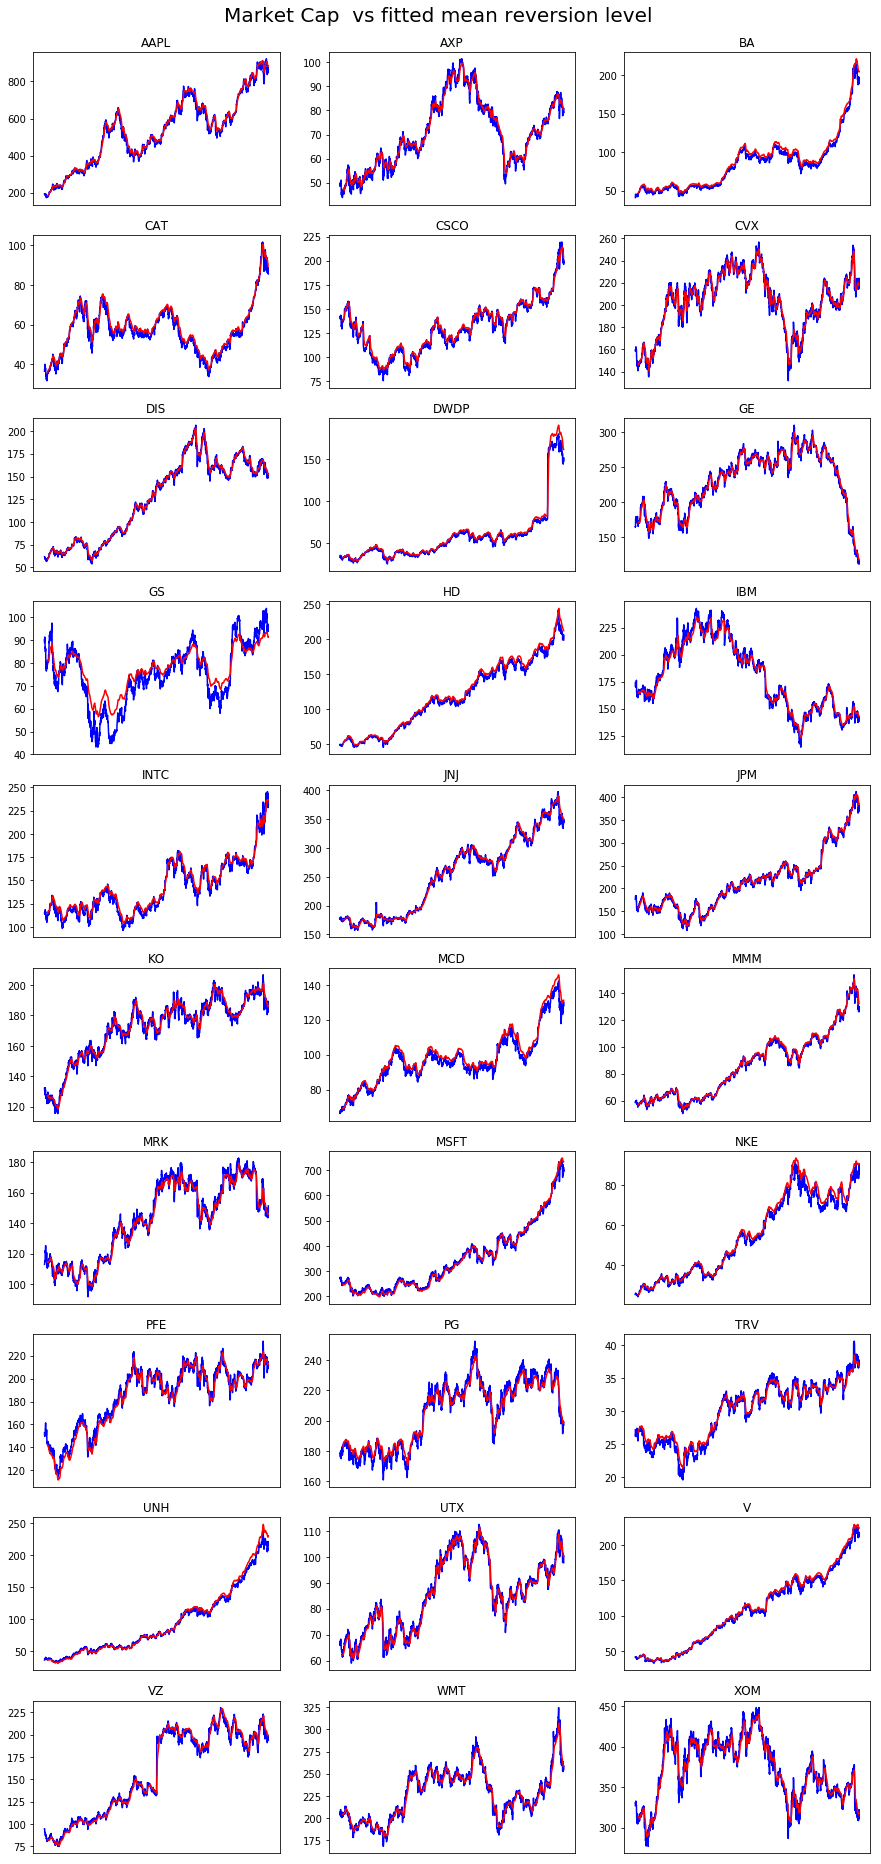

In [18]:
plt.show()

# Result

On running the model, it converges around 1500 to 1750 iterations. It perhaps due to the randomization of the weights at each initialization. The results are able to reproduce it, saved out a checkpoint file (.ckpt). We can see that the overlapping plot that we have convergence. The moving average signals have been calibrated.

## Part 2: Propose and analyse your own signals  (Max 10 points)

In this part, you will experiment with other signals. Propose a signal and explain why it is interesting to 
include this signal in the portfolio analysis. Then add your favorite signal or signals to the previous benchmarck signals (or alternatively you can replace them), and repeat the analysis of model calibration. State your conclusions.


# Data Manipulation

In [19]:

exp_wgt_mov_avg_window_a = 7
exp_wgt_mov_avg_window_b = 15

# https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.ewm.html
# Provides exponential weighted functions
# Then you take the .mean() to get the average.
exp_wgt_mov_avg_short = df_cap.ewm( span = exp_wgt_mov_avg_window_a,
                                              adjust = False ).mean()
exp_wgt_mov_avg_long = df_cap.ewm( span = exp_wgt_mov_avg_window_b,
                                             adjust = False ).mean()

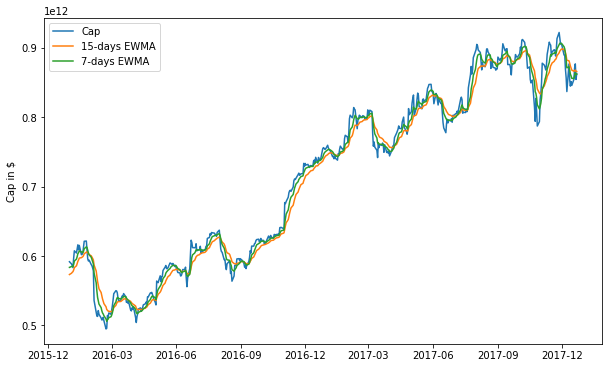

In [20]:
# This is similar code as the cell above but instead of 3 years of stock info, just using 2 years.
# Also changing rolling to exponential weighted moving average (left the original commented out.)
ticker = 'AAPL'
start_date = '2016-01-01'
end_date = '2017-12-31'

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1,1,1)

ax.plot(df_cap.loc[start_date:end_date, :].index, df_cap.loc[start_date:end_date, 'AAPL'], label='Cap')
# ax.plot(long_rolling.loc[start_date:end_date, :].index, long_rolling.loc[start_date:end_date, 'AAPL'], 
#           label = '%d-days SMA' % window_2)
ax.plot(exp_wgt_mov_avg_long.loc[start_date:end_date, :].index, exp_wgt_mov_avg_long.loc[start_date:end_date, 'AAPL'], 
            label = '%d-days EWMA' % exp_wgt_mov_avg_window_b)
ax.plot(exp_wgt_mov_avg_short.loc[start_date:end_date, :].index, exp_wgt_mov_avg_short.loc[start_date:end_date, 'AAPL'], 
         label = '%d-days EWMA' % exp_wgt_mov_avg_window_a)

ax.legend(loc='best')
ax.set_ylabel('Cap in $')

plt.show()

In [21]:

# Manipulate raw data
# NOTE: .sum() has axis 1 because we want the sum of the column which is just
#       1 ticker symbol.
#       .mean() will then take the mean average of all the ticker symbol 
average_market_cap = df_cap.sum(axis=1).mean()

# Average
short_ewma_average = exp_wgt_mov_avg_short / average_market_cap
long_ewma_average = exp_wgt_mov_avg_long / average_market_cap
df_cap_average = df_cap / average_market_cap
#
# By looking at the debug cells below, we see that both heads for the long and short de-meaned pandas Dataframes have NaN 
# (Not-a-number.)
# Going to only start with the first valid number
# Using .first_valid_index
# https://stackoverflow.com/questions/42137529/pandas-find-first-non-null-value-in-column
short_ewma_average_first_valid = (short_ewma_average 
                                    /
                                    short_ewma_average.loc[ short_ewma_average.first_valid_index() ])
long_ewma_average_first_valid = (long_ewma_average
                                   /
                                   long_ewma_average.loc[ long_ewma_average.first_valid_index() ])

# De-mean
# https://www.youtube.com/watch?v=E5PZR4YpBtM
short_ewma_demeaned = short_ewma_average_first_valid.pct_change(periods=1).shift(-1)
long_ewma_demeaned = long_ewma_average_first_valid.pct_change(periods=1).shift(-1)

In [22]:
# Clean data

# Drop last row
market_cap = df_cap_average[:-1]

# Drop not-a-numbers
signal_1 = short_ewma_demeaned.copy()
signal_2 = long_ewma_demeaned.copy()
#
signal_1 = signal_1.dropna()
signal_2 = signal_2.dropna()

# # Get rid rows where dates that do not match
market_cap = market_cap[ market_cap.index.isin(signal_1.index) & market_cap.index.isin(signal_2.index)]
signal_1 = signal_1[signal_1.index.isin( market_cap.index )]
signal_2 = signal_2[signal_2.index.isin( market_cap.index )]

In [23]:
# Get the amount of time steps
t = market_cap.shape[0]
t

2079

In [24]:
# Get the number of stocks
n = market_cap.shape[1]
n

30

In [25]:
start_date = '2010-1-1'
end_date = '2017-12-31'

# Only get the dates required
market_cap_focused = market_cap.loc[ start_date : end_date ]
signal_1_focused = signal_1.loc[ start_date : end_date ]
signal_2_focused = signal_2.loc[ start_date : end_date ]

# Mentioned in the instructions, 2 signals means k = 2
k = 2

In [26]:
# Creating a Pandas Dataframe to hold the results
results = pd.DataFrame( [],
                        index = market_cap_focused.columns,
                        columns = [ 'kappa',
                                    'sigma',
                                    'sigma^2',
                                    'w1',
                                    'w2'] )

In [27]:
# Tensorflow graph
tf.reset_default_graph()

# Input
x = tf.placeholder( shape = (None, n),
                    dtype = tf.float32,
                    name = 'x' )

# Signals
z1  = tf.placeholder( shape = (None,n),
                      dtype = tf.float32,
                      name = 'z1' ) 
z2  = tf.placeholder( shape = ( None, n),
                      dtype=tf.float32,
                      name = 'z2' )

# Variables
N_k = n
N_s = n
N_w = n
kappa = tf.get_variable( "kappa",
                         initializer = tf.random_uniform(
                                             [N_k], 
                                             minval = 0.0,
                                             maxval = 1.0) )
sigma = tf.get_variable( "sigma",
                         initializer = tf.random_uniform( 
                                             [N_s],
                                             minval=0.0,
                                             maxval=0.1) )

# Weights
#-------------------
w1_init = tf.random_normal( [N_w],
                            mean=0.5,
                            stddev=0.1 )
w2_init = 1 - w1_init
w1 = tf.get_variable( "w1",
                      initializer = w1_init)
w2 = tf.get_variable( "w2",
                      initializer=w2_init )

W1 = w1*tf.ones(n)
W2 = w2*tf.ones(n)


# Gaussian
#-------------------
mu    = tf.zeros( [n] )
Sigma = sigma*tf.ones( [n] )
theta1 = tf.multiply( W1,
                      z1)
theta2 = tf.multiply( W2,
                      z2)
scale  = tf.slice( x,
                   [0,0],
                   [1,-1] )
theta  = tf.multiply( scale,
                      tf.cumprod( 1 + tf.add( theta1,
                                              theta2) ) )

Kappa = kappa*tf.ones( [n] )

r = tf.divide( tf.subtract( tf.manip.roll( x,
                                           shift = -1,
                                           axis = 0),
                            x),
               x)
v = tf.subtract( r, 
                 tf.multiply( Kappa,
                              tf.subtract( theta,
                                           x) ) )
# NOTE: Do not use last row
vuse = tf.slice( v,
                 [0,0],
                 [tf.shape(v)[0]-1,-1] )

#  Constraint - No negative
#-------------------
clip_w1 = w1.assign(tf.maximum(0., w1))
clip_w2 = w2.assign(tf.maximum(0., w2))
clip = tf.group(clip_w1, clip_w2)

dist = tf.contrib.distributions.MultivariateNormalDiag(loc=mu, scale_diag=Sigma)
log_prob = dist.log_prob(vuse)
reg_term = tf.reduce_sum(tf.square(w1+w2-1))
neg_log_likelihood = -tf.reduce_sum(log_prob) + 0.01*reg_term

# Optimizer
#-------------------
optimizer = tf.train.AdamOptimizer(learning_rate=0.0001)
train_op = optimizer.minimize( neg_log_likelihood )

In [28]:
max_iteration = 5000
tolerence = 1e-15

In [29]:
# Save Tensorflow model because running the weight
saver = tf.train.Saver()

# Run Tensorflow
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    losses = sess.run([neg_log_likelihood], feed_dict={x: market_cap_focused, z1: signal_1_focused, z2: signal_2_focused})
    i=1
    
    # Calibrate print out
    print( "------------------- Calibration Calculating ----------------------" )
    print(" iter |       Loss       |   difference")
    
    while True:

        sess.run(train_op, feed_dict={x: market_cap_focused, z1: signal_1_focused, z2: signal_2_focused})
        sess.run(clip) # force weights to be non-negative

        # update loss
        new_loss = sess.run(neg_log_likelihood, feed_dict={x: market_cap_focused, z1: signal_1_focused, z2: signal_2_focused})
        loss_diff = np.abs(new_loss - losses[-1])
        losses.append(new_loss)

        if i%min(1000,(max_iteration/20))==1:
            print ("{:5} | {:16.4f} | {:12.4f}".format(i,new_loss,loss_diff))

        if loss_diff < tolerence:
            print('Loss function convergence in {} iterations!'.format(i))
            print('Old loss: {}  New loss: {}'.format(losses[-2],losses[-1]))
            break

        if i >= max_iteration:
            print('Max number of iterations reached without convergence.')
            break

        i += 1

    # Put data in pandas Dataframe.
    results['kappa'] = sess.run(kappa)
    results['sigma'] = sess.run(sigma)
    results['sigma^2'] = sess.run(sigma)**2
    results['w1'] = sess.run(W1)
    results['w2'] = sess.run(W2)

    fitted_means = sess.run(theta, feed_dict={x: market_cap_focused, z1: signal_1_focused, z2: signal_2_focused})
    mean_levels = pd.DataFrame(fitted_means,index=market_cap_focused.index,columns=market_cap_focused.columns)
    
    
    print( "------------------- Calibration Results ----------------------" )
    print(results.round(4))
    
    
    save_path = saver.save(sess, './part02_model.ckpt')
    print( 'Model saved in path: {}'.format(save_path) )


------------------- Calibration Calculating ----------------------
 iter |       Loss       |   difference
    1 |     -127550.4609 |     434.2734
  251 |     -156688.4688 |      88.7656
  501 |     -173155.3125 |      51.3125
  751 |     -180504.5625 |       0.1250
 1001 |     -180521.1094 |       0.0312
Loss function convergence in 1032 iterations!
Old loss: -180523.0625  New loss: -180523.0625
------------------- Calibration Results ----------------------
       kappa   sigma  sigma^2      w1      w2
AAPL  0.6765  0.0157   0.0002  0.5314  0.4738
AXP   0.7367  0.0148   0.0002  0.5792  0.4209
BA    0.6533  0.0151   0.0002  0.5474  0.5121
CAT   0.7692  0.0169   0.0003  0.4619  0.5858
CSCO  1.1016  0.0159   0.0003  0.4218  0.5577
CVX   0.3534  0.0134   0.0002  0.7769  0.2129
DIS   0.2653  0.0135   0.0002  0.6444  0.3801
DWDP  0.2888  0.0273   0.0007  0.5288  0.5954
GE    0.7241  0.0140   0.0002  0.4325  0.5638
GS    0.2726  0.0168   0.0003  0.3357  0.3737
HD    0.6958  0.0126   0.0002  

In [30]:
# Save the dataframe
results.to_csv('df_results_part02.csv')
results.to_csv('df_mean_levels_part02.csv')

In [31]:
data = df_cap
theta = mean_levels
start_date='2010-01-01'
end_date='2017-12-31'
nplot = 30
scale = 1
title = 'Market Cap '

avg_mkt_cap = data.sum(axis=1).mean() # average market cap over the period

N = data.shape[1]


if N > nplot: N = nplot

plt.figure(figsize=(15,N))
plt.suptitle(title + ' vs fitted mean reversion level',size=20)
ytop = 0.96-0.4*np.exp(-N/5)
plt.subplots_adjust(top=ytop)

stocks = data.columns[:N]
for index, stock in enumerate(stocks,1):
    plt.subplot(np.ceil(N/3),3,index)
    plt.plot(scale*(1/1e9)*data.loc[start_date:end_date][stock],color='blue',label='Market cap ($Bn)')
    plt.plot(scale*(avg_mkt_cap/1e9)*theta.loc[start_date:end_date][stock],color='red',label='Mean reversion level')
    plt.title(stock,size=12)
    plt.xticks([])

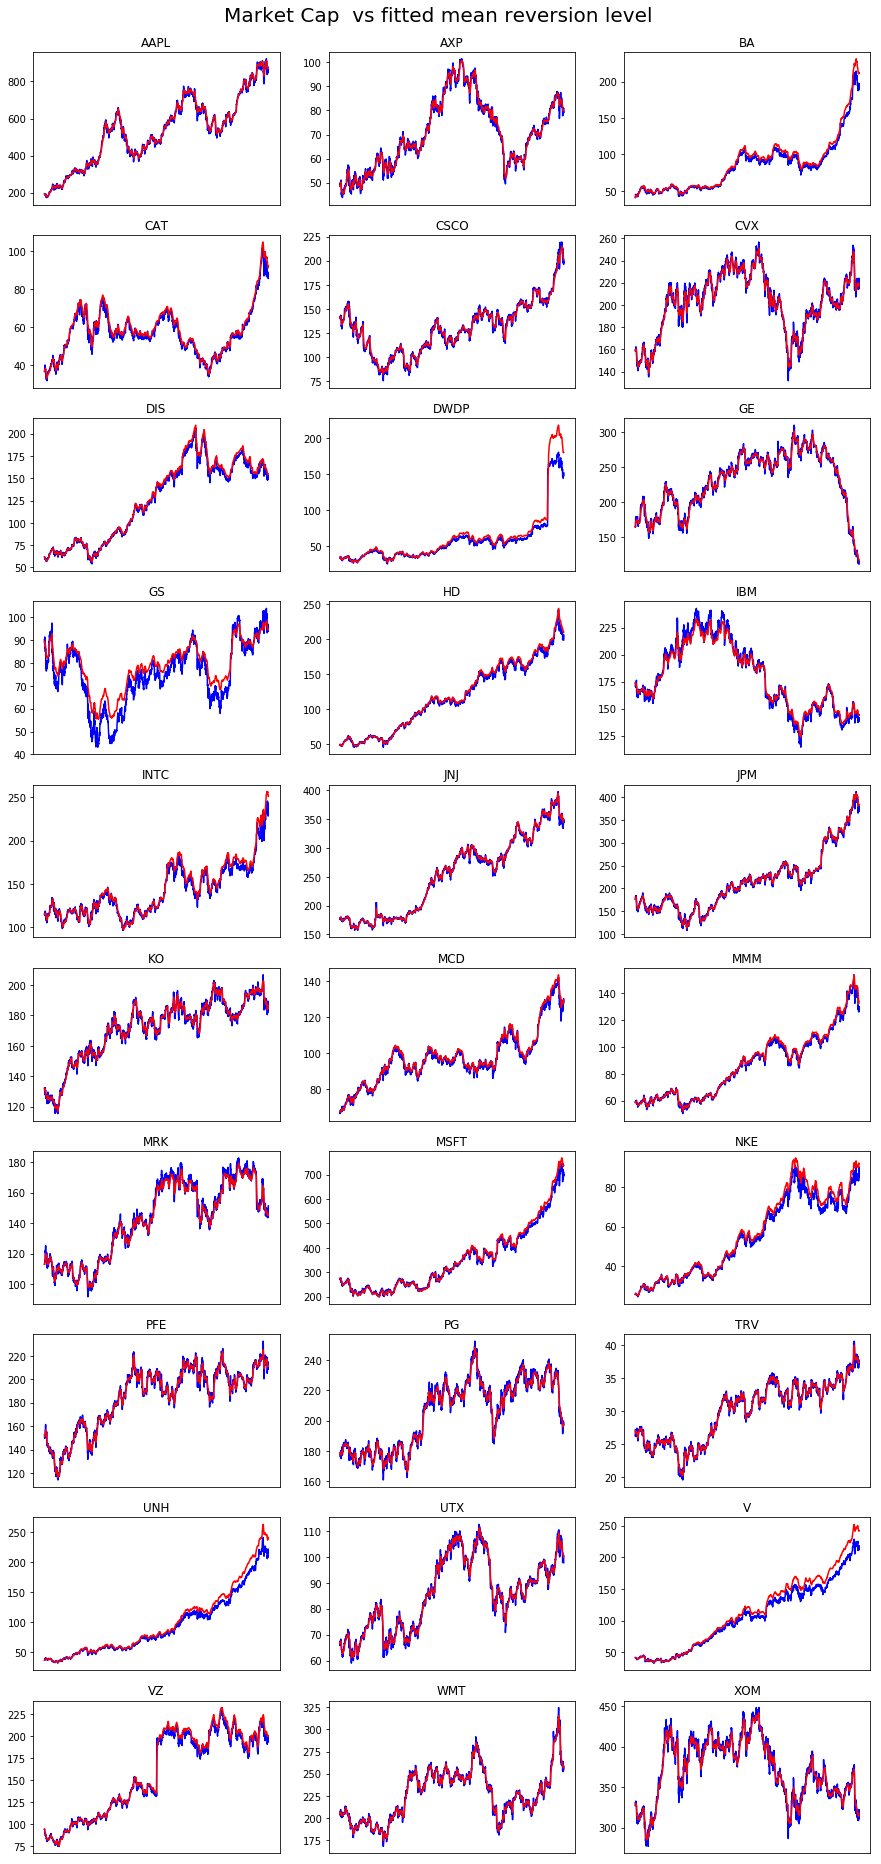

In [32]:
plt.show()

# Result

The model converged at 1111 iterations, unlike Part 1 which converged around 1500 to 1700 iterations. It may be due to the randomization of the weights at each initialization. Result suggests, the weight 1 is more favorable which is assigned to our short position. As we can see from the overlapping curves plotted, which means we converged to the predicted value

## Part 3: Can you do it for the S&P500 market portfolio? (Max 10 point)

Try to repeat your analysis for the S&P500 portfolio. 

The data can be obtained from Course 2 "Fundamentals of Machine Learning in Finance" in this Specialization.

# Data Loading

In [33]:
asset_prices = pd.read_csv('spx_holdings_and_spx_closeprice_m2-ex3.csv',
                     date_parser=lambda dt: pd.to_datetime(dt, format='%Y-%m-%d'),
                     index_col = 0).dropna()

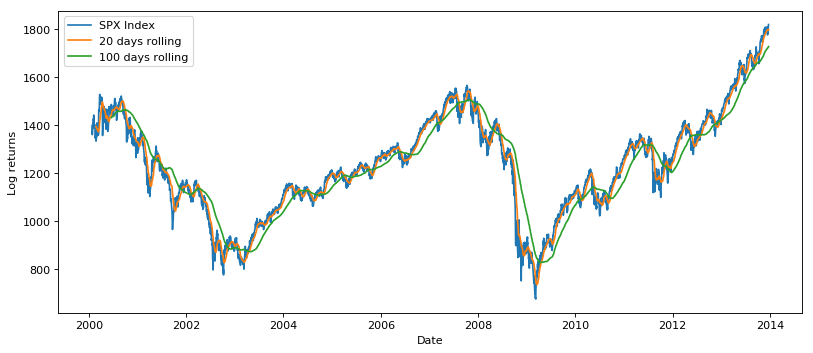

In [34]:
# Get the SPX time series. This now returns a Pandas Series object indexed by date.# Get t 
spx_index = asset_prices.loc[:, 'SPX']

short_rolling_spx = pd.core.series.Series(np.zeros(len(asset_prices.index)), index=asset_prices.index)
long_rolling_spx = short_rolling_spx

# Calculate the 20 and 100 days moving averages of log-returns
### START CODE HERE ### (≈ 2 lines of code)
### ...
short_rolling_spx = spx_index.rolling(20).mean()
long_rolling_spx = spx_index.rolling(100).mean()
### END CODE HERE ###

# Plot the index and rolling averages
fig=plt.figure(figsize=(12, 5), dpi= 80, facecolor='w', edgecolor='k')
ax = fig.add_subplot(1, 1, 1)
ax.plot(spx_index.index, spx_index, label='SPX Index')
ax.plot(short_rolling_spx.index, short_rolling_spx, label='20 days rolling')
ax.plot(long_rolling_spx.index, long_rolling_spx, label='100 days rolling')
ax.set_xlabel('Date')
ax.set_ylabel('Log returns')
ax.legend(loc=2)
plt.show()



In the below step we calculate the percent returns, also known as simple returns using asset_prices. assign the result to variable asset_returns. Keep only not-nan values in the resulting pandas.DataFrame

Calculate de-meaned returns and scale them by standard deviation $\sigma$. Assign result to normed_returns variable.
We now compute stock returns and normalize stock returns data by subtracting the mean and dividing by standard diviation. This normalization is required by PCA.

In [35]:
window_1 = 10

short_rolling = asset_prices.rolling(window=window_1).mean()

In [36]:
window_2 = 30
long_rolling = asset_prices.rolling(window=window_2).mean()

In [37]:
# NOTE: .sum() has axis 1 because we want the sum of the column which is just
#       1 ticker symbol.
#       .mean() will then take the mean average of all the ticker symbol 
average_market_cap = asset_prices.sum(axis=1).mean()

# Average
short_rolling_average = short_rolling / average_market_cap
long_rolling_average = long_rolling / average_market_cap
df_cap_average = df_cap / average_market_cap
#
# By looking at the debug cells below, we see that both heads for the long and short de-meaned pandas Dataframes have NaN 
# (Not-a-number.)
# Going to only start with the first valid number
# Using .first_valid_index
# https://stackoverflow.com/questions/42137529/pandas-find-first-non-null-value-in-column
short_rolling_average_first_valid = (short_rolling_average 
                                    /
                                    short_rolling_average.loc[ short_rolling_average.first_valid_index() ])
long_rolling_average_first_valid = (long_rolling_average
                                   /
                                   long_rolling_average.loc[ long_rolling_average.first_valid_index() ])


# De-mean
# https://www.youtube.com/watch?v=E5PZR4YpBtM
short_rolling_demeaned = short_rolling_average_first_valid.pct_change(periods=1).shift(-1)
long_rolling_demeaned = long_rolling_average_first_valid.pct_change(periods=1).shift(-1)

In [38]:
# Clean data

# Drop last row
market_cap = asset_prices[:-1]

# Drop not-a-numbers
signal_1 = short_rolling_demeaned.copy()
signal_2 = long_rolling_demeaned.copy()
#
signal_1 = signal_1.dropna()
signal_2 = signal_2.dropna()

# # Get rid rows where dates that do not match
market_cap = market_cap[ market_cap.index.isin(signal_1.index) & market_cap.index.isin(signal_2.index)]
signal_1 = signal_1[signal_1.index.isin( market_cap.index )]
signal_2 = signal_2[signal_2.index.isin( market_cap.index )]

In [39]:
# add dates
dates = pd.bdate_range(start='2010-01-04', end=None, periods=asset_prices.shape[0], freq='B')
asset_prices['date'] = dates

asset_prices.set_index('date',inplace=True)
asset_prices.head()

,A,AA,AAPL,ABC,ABT,ADBE,ADI,ADM,ADP,ADSK,...,STJ,SVU,SWY,TEG,TER,TGNA,THC,X,MAR.1,SPX
date,,,,,,,,,,,,,,,,,,,,,
2010-01-04,46.1112,78.9443,3.9286,4.5485,13.7898,15.6719,48.0313,10.8844,39.5477,8.1250,...,5.5918,86.6178,26.3983,11.3873,65.8677,22.1921,60.9705,20.7086,12.2457,1398.56
2010-01-05,45.8585,77.8245,3.6295,4.5485,14.2653,14.3906,47.7500,10.7143,38.5627,7.7188,...,5.4520,82.4218,27.4137,11.2230,60.3487,21.7558,62.3032,20.1183,12.0742,1360.16
2010-01-06,44.5952,78.0345,3.7054,4.3968,14.5730,13.7656,46.7500,10.6576,37.3807,7.6406,...,5.5499,86.3181,28.2444,11.0862,62.1484,22.0533,60.6373,19.5772,12.1722,1394.46
2010-01-07,47.8377,80.7640,3.5804,4.5333,14.7128,13.9688,49.0000,10.8844,37.9717,7.9219,...,5.4240,83.0212,28.7982,11.1683,67.3674,22.2120,60.4708,19.5772,12.5151,1409.28
2010-01-08,51.5434,83.4934,3.5290,4.5788,14.7968,15.3281,48.1250,10.6576,35.9032,7.9688,...,5.3541,81.5226,28.6136,11.1956,68.9271,22.6483,62.4698,19.5281,12.3192,1409.12


In [40]:
start_date = '2010-01-04'
end_date = '2013-12-20'

# Only get the dates required
market_cap_focused = market_cap.loc[ start_date : end_date ]
signal_1_focused = signal_1.loc[ start_date : end_date ]
signal_2_focused = signal_2.loc[ start_date : end_date ]

# Mentioned in the instructions, 2 signals means k = 2
k = 2

In [41]:
# Get the amount of time steps
t = market_cap.shape[0]
t

3463

In [42]:
# Get the number of stocks
n = market_cap.shape[1]
n

419

In [43]:

# Creating a Pandas Dataframe to hold the results
results = pd.DataFrame( [],
                        index = market_cap_focused.columns,
                        columns = [ 'kappa',
                                    'sigma',
                                    'sigma^2',
                                    'w1',
                                    'w2'] )

In [44]:
def check_for_nulls(df):
    """
    Test and report number of NAs in each column of the input data frame
    :param df: pandas.DataFrame
    :return: None
    """
    for col in df.columns.values:
        num_nans = np.sum(df[col].isnull())
        if num_nans > 0:
            print('%d Nans in col %s' % (num_nans, col))
    print('New shape of df: ', df.shape)

In [45]:
check_for_nulls(market_cap_focused)

New shape of df:  (997, 419)


In [46]:
# Tensorflow graph
tf.reset_default_graph()

# Input
x = tf.placeholder( shape = (None, n),
                    dtype = tf.float32,
                    name = 'x' )

# Signals
z1  = tf.placeholder( shape = (None,n),
                      dtype = tf.float32,
                      name = 'z1' ) 
z2  = tf.placeholder( shape = ( None, n),
                      dtype=tf.float32,
                      name = 'z2' )

# Variables
N_k = n
N_s = n
N_w = n
kappa = tf.get_variable( "kappa",
                         initializer = tf.random_uniform(
                                             [N_k], 
                                             minval = 0.0,
                                             maxval = 1.0) )
sigma = tf.get_variable( "sigma",
                         initializer = tf.random_uniform( 
                                             [N_s],
                                             minval=0.0,
                                             maxval=0.1) )

# Weights
#-------------------
w1_init = tf.random_normal( [N_w],
                            mean=0.5,
                            stddev=0.1 )
w2_init = 1 - w1_init
w1 = tf.get_variable( "w1",
                      initializer = w1_init)
w2 = tf.get_variable( "w2",
                      initializer=w2_init )

W1 = w1*tf.ones(n)
W2 = w2*tf.ones(n)


# Gaussian
#-------------------
mu    = tf.zeros( [n] )
Sigma = sigma*tf.ones( [n] )
theta1 = tf.multiply( W1,
                      z1)
theta2 = tf.multiply( W2,
                      z2)
scale  = tf.slice( x,
                   [0,0],
                   [1,-1] )
theta  = tf.multiply( scale,
                      tf.cumprod( 1 + tf.add( theta1,
                                              theta2) ) )

Kappa = kappa*tf.ones( [n] )

r = tf.divide( tf.subtract( tf.manip.roll( x,
                                           shift = -1,
                                           axis = 0),
                            x),
               x)
v = tf.subtract( r, 
                 tf.multiply( Kappa,
                              tf.subtract( theta,
                                           x) ) )
# NOTE: Do not use last row
vuse = tf.slice( v,
                 [0,0],
                 [tf.shape(v)[0]-1,-1] )

#  Constraint - No negative
#-------------------
clip_w1 = w1.assign(tf.maximum(0., w1))
clip_w2 = w2.assign(tf.maximum(0., w2))
clip = tf.group(clip_w1, clip_w2)

dist = tf.contrib.distributions.MultivariateNormalDiag(loc=mu, scale_diag=Sigma)
log_prob = dist.log_prob(vuse)
reg_term = tf.reduce_sum(tf.square(w1+w2-1))
neg_log_likelihood = -tf.reduce_sum(log_prob) + 0.01*reg_term

# Optimizer
#-------------------
optimizer = tf.train.AdamOptimizer(learning_rate=0.0001)
train_op = optimizer.minimize( neg_log_likelihood )


In [47]:
max_iteration = 5000
tolerence = 1e-15

In [48]:
saver = tf.train.Saver()

# Run Tensorflow
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    losses = sess.run([neg_log_likelihood], feed_dict={x: market_cap_focused, z1: signal_1_focused, z2: signal_2_focused})
    i=1
    
    # Calibrate print out
    print( "------------------- Calibration Calculating ----------------------" )
    print(" iter |       Loss       |   difference")
    
    while True:

        sess.run(train_op, feed_dict={x: market_cap_focused, z1: signal_1_focused, z2: signal_2_focused})
        sess.run(clip) # force weights to be non-negative

        # update loss
        new_loss = sess.run(neg_log_likelihood, feed_dict={x: market_cap_focused, z1: signal_1_focused, z2: signal_2_focused})
        loss_diff = np.abs(new_loss - losses[-1])
        losses.append(new_loss)

        if i%min(1000,(max_iteration/20))==1:
            print ("{:5} | {:16.4f} | {:12.4f}".format(i,new_loss,loss_diff))

        if loss_diff < tolerence:
            print('Loss function convergence in {} iterations!'.format(i))
            print('Old loss: {}  New loss: {}'.format(losses[-2],losses[-1]))
            break

        if i >= max_iteration:
            print('Max number of iterations reached without convergence.')
            break

        i += 1

    # Put data in pandas Dataframe.
    results['kappa'] = sess.run(kappa)
    results['sigma'] = sess.run(sigma)
    results['sigma^2'] = sess.run(sigma)**2
    results['w1'] = sess.run(W1)
    results['w2'] = sess.run(W2)

    fitted_means = sess.run(theta, feed_dict={x: market_cap_focused, z1: signal_1_focused, z2: signal_2_focused})
    mean_levels = pd.DataFrame(fitted_means,index=market_cap_focused.index,columns=market_cap_focused.columns)
    
    
    print( "------------------- Calibration Results ----------------------" )
    print(results.round(4))
    
    
    save_path = saver.save(sess, './part01_model.ckpt')
    print( 'Model saved in path: {}'.format(save_path) )


------------------- Calibration Calculating ----------------------
 iter |       Loss       |   difference
    1 |  2529965824.0000 | 358535936.0000
  251 |   237508192.0000 |  658976.0000
  501 |   142212080.0000 |  224576.0000
  751 |   102074120.0000 |  115208.0000
 1001 |    79366552.0000 |   71192.0000
 1251 |    64531892.0000 |   49352.0000
 1501 |    53961532.0000 |   36244.0000
 1751 |    45981928.0000 |   28072.0000
 2001 |    39709212.0000 |   22236.0000
 2251 |    34627468.0000 |   18260.0000
 2501 |    30416244.0000 |   15318.0000
 2751 |    26862810.0000 |   13070.0000
 3001 |    23821960.0000 |   11338.0000
 3251 |    21190842.0000 |    9734.0000
 3501 |    18891590.0000 |    8586.0000
 3751 |    16867176.0000 |    7678.0000
 4001 |    15075595.0000 |    6739.0000
 4251 |    13480674.0000 |    6058.0000
 4501 |    12053584.0000 |    5435.0000
 4751 |    10773170.0000 |    4873.0000
Max number of iterations reached without convergence.
------------------- Calibration Resul

In [49]:
# Save the dataframe
results.to_csv('df_results_part01.csv')
results.to_csv('df_mean_levels_part01.csv')

In [51]:
#data = asset_prices
data = asset_prices.iloc[:,:30]
theta = mean_levels
start_date='2010-01-04'
end_date='2013-12-20'

# nplot = 418
nplot = 30
scale = 1
title = 'Market Cap '

avg_mkt_cap = data.sum(axis=1).mean() # average market cap over the period

N = data.shape[1]

if N > nplot: N = nplot

plt.figure(figsize=(15,30))
plt.suptitle(title + ' vs fitted mean reversion level',size=20)
ytop = 0.96-0.4*np.exp(-N/5)
plt.subplots_adjust(top=ytop)

stocks = data.columns[:N]
for index, stock in enumerate(stocks,1):
    plt.subplot(np.ceil(N/3),3,index)
    plt.plot(scale*(1/1e9)*data.loc[start_date:end_date][stock],color='blue',label='Market cap ($Bn)')
    plt.plot(scale*(avg_mkt_cap/1e9)*theta.loc[start_date:end_date][stock],color='red',label='Mean reversion level')
    plt.title(stock,size=12)
    plt.xticks([])

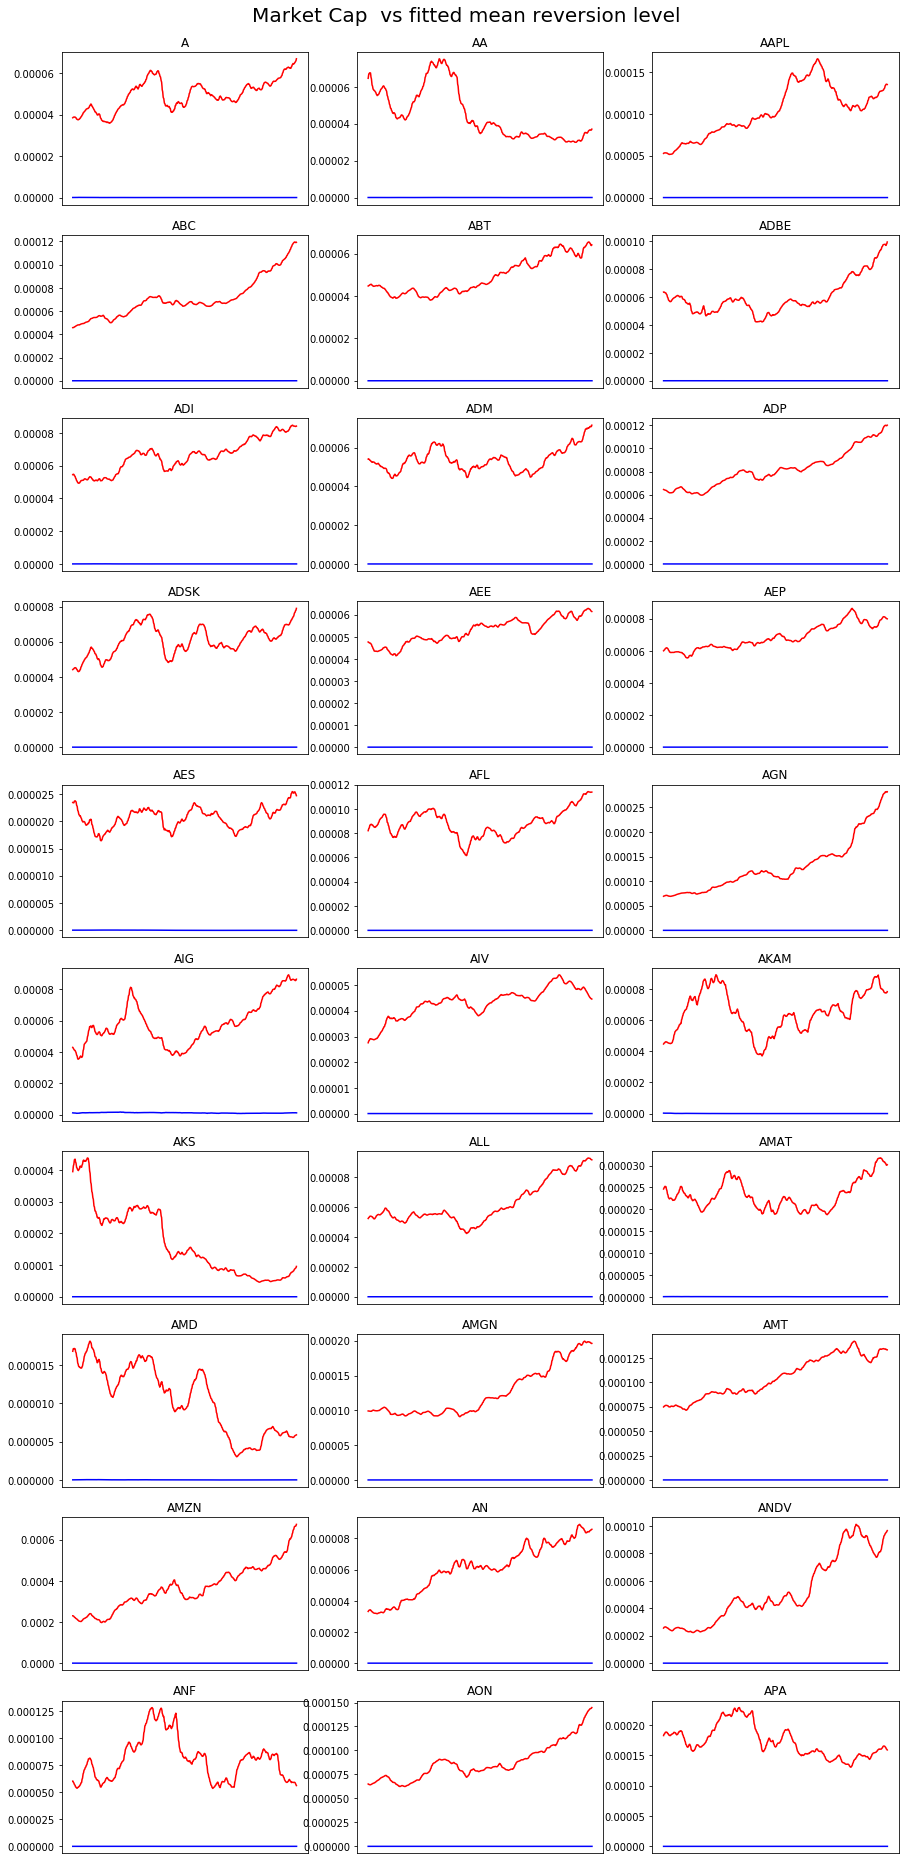

In [52]:
plt.show()

# Result

Unlike the previous two models, part 3 model did not converge ecen after the 5000th iterations. It may because of the size of the stocks. previous two part has 30 stocks and this involved 418 stocks. Therefore principal component analysis may be better idea for dimenssional reduction. 

## Part 4 (Optional): Show me something else.

Here you can develop any additional analysis of the model that you may find interesting (One possible suggestion is 
presented above, but you should feel free to choose your own topic). Present your case and finding/conclusions.


In [ ]:
# Put the rest of your code and analysis for Part 3 here.